this script is for visualizing the results from the case study

In [221]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy import stats
import numpy as np
import pandas as pd

In [222]:
from src.game_theory_helpers import powerset, is_convex_game, get_loo, get_shapley_value, get_nash_bargaining_solution, get_banzhaf_value, core_nonempty, game_is_superadditive, make_game_superadditive
from src.nucleolus import get_nucleolus
from src.least_core_nucleolus import get_least_core_nucleolus

In [223]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")

# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]

# Create extended cycle: first full alpha, then alpha=0.5
colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]

# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    # "font.serif": ["Computer Modern Roman"],
    "mathtext.fontset": "cm", # 'cm' stands for Computer Modern
    "font.size": 15,  # plt.rcParams.update({'font.size': 15})
})

C:\Users\carlv\AppData\Local\Temp\ipykernel_15924\940924037.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


# Set Parameters

In [224]:
# PARAMS
MAKE_games_superadditive = True   # use superadditive formulation
MAKE_REALIZED_SUPERADDITIVE = False
GAME_types_to_plot = ['Shapley']  # ['Shapley', 'Nucleolus', 'Sub-Game']
# main_path = 'pics/mp_ilmar_K20_HPF25/'
main_path = 'pics/mp_ilmar_spring/'
# main_path = 'pics/mp_optimal_spring/'
# main_path = 'pics/v_TESTING2/'
services = ['FFR + FCR-D']  # list of services to visualize

In [225]:
dvpps_infos = {}  # dictionary to hold dvpp info dataframes
df_expected = pd.DataFrame()
df_realized = pd.DataFrame()
dvpp_info = pd.DataFrame()
df_bids = pd.DataFrame()

df_expected = pd.read_csv(f'{main_path}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_expected.columns = [tuple(c for c in col if c!='nan') for col in df_expected.columns.values]
df_realized = pd.read_csv(f'{main_path}values_DPF.csv', index_col=[0,1], header=[0,1,2])
df_realized.columns = [tuple(c for c in col if c!='nan') for col in df_realized.columns.values]
for service in services:
    dvpps_infos[service] = pd.read_csv(f'{main_path}dvpp_info_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

## Pure-Nucleolus Reward Split

In [226]:
# get reward split of devices
players = [c[0] for c in df_expected.columns if len(c)==1]
idxes = pd.MultiIndex.from_product((df_expected.index.get_level_values(1), ['E-Value', 'E-Nucleolus', 'R-Value', 'R-Nucleolus']))
df_reward_split = pd.DataFrame(0.0, index=idxes, columns=players)
superadditivity_counter = 0
convexity_counter = 0
core_non_empty_counter = 0
for idx, row in df_expected.iterrows():
    # 1. Expected game convert to dictionary
    v = {frozenset(k): val for k, val in row.items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    # v = make_game_superadditive(v, players)  # ensure superadditivity
    if game_is_superadditive(v, players):
        superadditivity_counter += 1
        nucleolus = get_nucleolus(v, players)
    else:
        print(f"for time {idx[0]}, expected game is not superadditive.")
        print(v)
        nucleolus = get_least_core_nucleolus(v, players)
    if is_convex_game(v, players):
        convexity_counter += 1
    if core_nonempty(v, players):
        core_non_empty_counter += 1
    df_reward_split.loc[(idx[1], 'E-Nucleolus'), list(k for k in nucleolus.keys())] = list(nucleolus.values())
    df_reward_split.loc[(idx[1], 'E-Value'), list(p for p in players)] = [v[frozenset({p})] for p in players]
    # 2. Realized game convert to dictionary
    v_realized = {frozenset(k): val for k, val in df_realized.loc[idx].items()}
    v_realized[frozenset()] = 0.0  # ensure empty set
    nucleolus_realized = get_least_core_nucleolus(v_realized, players)
    df_reward_split.loc[(idx[1], 'R-Nucleolus'), list(k for k in nucleolus_realized.keys())] = list(nucleolus_realized.values())
    df_reward_split.loc[(idx[1], 'R-Value'), list(p for p in players)] = [v_realized[frozenset({p})] for p in players]

for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 3.63324, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 0.9375, frozenset({'PV', 'Wind'}): 2.50825, frozenset({'BESS', 'PV'}): 5.00703, frozenset({'BESS', 'Wind'}): 0.9375, frozenset({'BESS', 'PV', 'Wind'}): 5.18164, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 7.88848, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 1.5625, frozenset({'PV', 'Wind'}): 5.31613, frozenset({'BESS', 'PV'}): 10.14824, frozenset({'BESS', 'Wind'}): 1.5625, frozenset({'BESS', 'PV', 'Wind'}): 10.39081, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{frozenset({'PV'}): 7.50653, frozenset({'Wind'}): 0.0, frozenset({'BESS'}): 1.0125, frozenset({'PV', 'Wind'}): 4.92356, frozenset({'BESS', 'PV'}): 9.42042, frozenset({'BESS', 'Wind'}): 1.0125, frozenset({'BESS', 'PV', 'Wind'}): 9.42042, frozenset(): 0.0}
for time FFR + FCR-D, expected game is not superadditive.
{

In [227]:
print(f"For {main_path}, out of {len(df_expected)} games, {superadditivity_counter} superadditive, {convexity_counter} convex and {core_non_empty_counter} non-empty core.") 

For pics/mp_ilmar_spring/, out of 168 games, 53 superadditive, 46 convex and 102 non-empty core.


# Reward Split with New Method

In [228]:
from src.game_theory_helpers import evaluate_full_game, solve_optimal_partition

In [229]:
df_rewards = evaluate_full_game(df_expected, df_realized, MAKE_games_superadditive=MAKE_games_superadditive,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                print_warnings=False)

In [230]:
df_rewards.index.names = ['Index', 'Time', 'Value']

In [231]:
df_fc_reward = df_rewards[['PV', 'Wind', 'BESS']].xs(('Forecasted', 'Reward'), level=['Time', 'Value'])
# select only rows where all devices have non-zero forecasted reward
df_nonzero = df_fc_reward[(df_fc_reward > 0).any(axis=1)]

In [232]:
# print type of game for df_nonzero
nonzero_hours = df_nonzero.index.values
print("For NON-ZERO hours:")
print("For FORECASTED game:")
print(df_rewards.loc[(nonzero_hours, 'Forecasted', 'Reward'), 'Method'].value_counts())
print(f"out of {len(nonzero_hours)}.")
print("For REALIZED game:")
print(df_rewards.loc[(nonzero_hours, 'Realized', 'Reward'), 'Method'].value_counts())
print(f"out of {len(nonzero_hours)}.")

For NON-ZERO hours:
For FORECASTED game:
Method
Shapley      144
Nucleolus     15
Name: count, dtype: int64
out of 159.
For REALIZED game:
Method
Shapley      144
Nucleolus     15
Name: count, dtype: int64
out of 159.


In [233]:
hours = df_rewards.index.get_level_values(0).unique()
print("For ALL hours:")
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method'].value_counts())
print(f"out of {len(hours)}.")

For ALL hours:
Method
Shapley      153
Nucleolus     15
Name: count, dtype: int64
out of 168.


In [234]:
# also show realized game
print(df_rewards.loc[(hours, 'Realized', 'Reward'), 'Method-Realized'].value_counts())
print(f"out of {len(hours)}.")

Method-Realized
Shapley      135
Sub-Game      20
Nucleolus     13
Name: count, dtype: int64
out of 168.


In [235]:
# new multiindex
idxs1 = df_rewards.index.get_level_values(0).unique().values
idxs2 = df_rewards.index.get_level_values(1).unique().values
idxs3 = df_rewards.index.get_level_values(2).unique().values
idxs2_new = []
for i in idxs2:
    # append idx3
    for j in idxs3:
        idxs2_new.append(f'{i}-{j}')

In [236]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Dark2.colors[1:])

In [237]:
df_rewards.index = pd.MultiIndex.from_product([idxs1, idxs2_new])

In [238]:
devices = ['PV', 'Wind', 'BESS']

In [239]:
df_plot = df_rewards[devices]
df_mean = df_plot.groupby(level=1).mean()
df_mean = df_mean.transpose()

In [240]:
plt.rcParams.update({'font.size': 15})

In [241]:
# measure percentage increase of cooperative reward vs individual value
df_mean.sum()['Realized-Reward'] / df_mean.sum()['Realized-Value']

1.108874190040693

### convert to latex table

In [242]:
df_rewards

PV       Wind      BESS  \
2025-04-06 00:00:00 Forecasted-Value        0.0        0.0       1.0   
                    Forecasted-Reward       0.0        0.0       1.0   
                    Realized-Value          0.0        0.0       1.0   
                    Realized-Reward         0.0   0.272155  1.272155   
2025-04-06 01:00:00 Forecasted-Value        0.0        0.0    0.9375   
...                                         ...        ...       ...   
2025-04-12 22:00:00 Realized-Reward         0.0  32.591445  9.000085   
2025-04-12 23:00:00 Forecasted-Value        0.0   22.84623     3.125   
                    Forecasted-Reward  0.042645   26.89796  7.112115   
                    Realized-Value          0.0   36.41095     3.125   
                    Realized-Reward         0.0   39.85874   6.57279   

                                          Method Method-Realized  
2025-04-06 00:00:00 Forecasted-Value     Shapley         Shapley  
                    Forecasted-Reward    Shapley         Shapley  
                    Realized-Value       Shapley         Shapley  
                    Realized-Reward      Shapley         Shapley  
2025-04-06 01:00:00 Forecasted-Value     Shapley         Shapley  
...                                          ...             ...  
2025-04-12 22:00:00 Realized-Reward      Shapley         Shapley  
2025-04-12 23:00:00 Forecasted-Value   Nucleolus         Shapley  
                    Forecasted-Reward  Nucleolus         Shapley  
                    Realized-Value     Nucleolus         Shapley  
                    Realized-Reward    Nucleolus         Shapley  

[672 rows x 5 columns]

## Main Reward Plot

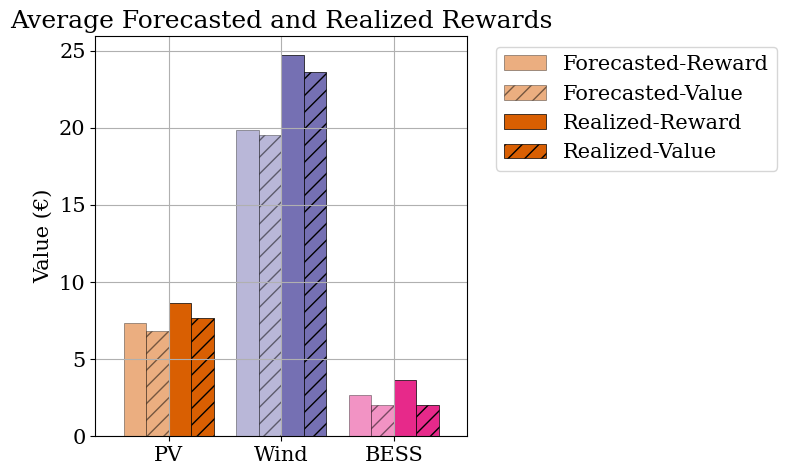

In [243]:
# define colors
device_colors = {
    'PV': (217/255, 95/255, 2/255),
    'Wind': (117/255, 112/255, 179/255),
    'BESS': (231/255, 41/255, 138/255)
}

# 3. Create the Plot
fig, ax = plt.subplots(figsize=(8, 5))
df_mean.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    if col_idx in [0, 1]:
        alpha = 0.5
        
    # "bars 2 and 4 should be hatch='//'" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_mean.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Average Forecasted and Realized Rewards")
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
plt.tight_layout()
plt.grid()
# plt.savefig('custom_bar_plot.png')

In [244]:
def assess_distribution_fit(data, distributions_to_test):
    """
    Fits and compares distributions using the Maximum Likelihood Estimation 
    (MLE) for fitting and the Kolmogorov-Smirnov (KS) test for scoring.
    """
    results = []
    
    # 💡 The list of distributions you want to check
    # Other common choices: 'weibull_min', 'lognorm', 'gamma', 'beta'
    
    for dist_name in distributions_to_test:
        dist = getattr(stats, dist_name)
        
        try:
            # 1. Fit the parameters using Maximum Likelihood Estimation (MLE)
            params = dist.fit(data)
            
            # 2. Perform the KS test to compare the data to the fitted distribution
            # H0: The data comes from the specified distribution
            ks_stat, p_value = stats.kstest(data, dist_name, args=params)
            
            results.append({
                'Distribution': dist_name,
                'KS Statistic': ks_stat, # Lower is better
                'P-Value': p_value      # Higher (ideally > 0.05) is better
            })
        except Exception:
            # Catch distributions that might fail to converge on parameters
            results.append({'Distribution': dist_name, 'KS Statistic': np.nan, 'P-Value': np.nan})
            
    # Sort by the KS Statistic to find the best fit quickly
    df = pd.DataFrame(results).sort_values(by='KS Statistic', ascending=True)
    
    # 
    
    return df

# Example Usage (Use your actual data instead of this random sample)
data = np.random.normal(loc=5, scale=1.5, size=100)
test_dists = ['norm', 't', 'laplace', 'expon']

fit_results = assess_distribution_fit(data, test_dists)
print(fit_results)

  Distribution  KS Statistic       P-Value
1            t      0.053465  9.226534e-01
0         norm      0.053746  9.197887e-01
2      laplace      0.080728  5.066214e-01
3        expon      0.347120  2.858015e-11


For Forecasted-Reward, 3796.9 values above 20, 1219.4 values below or equal to 20.
For Forecasted-Reward, 67 counts above 20, 437 counts below or equal to 20.
13.29% of values make up 75.69% of the total reward.
For Realized-Reward, 4950.8 values above 20, 1352.8 values below or equal to 20.
For Realized-Reward, 81 counts above 20, 402 counts below or equal to 20.
16.77% of values make up 78.54% of the total reward.


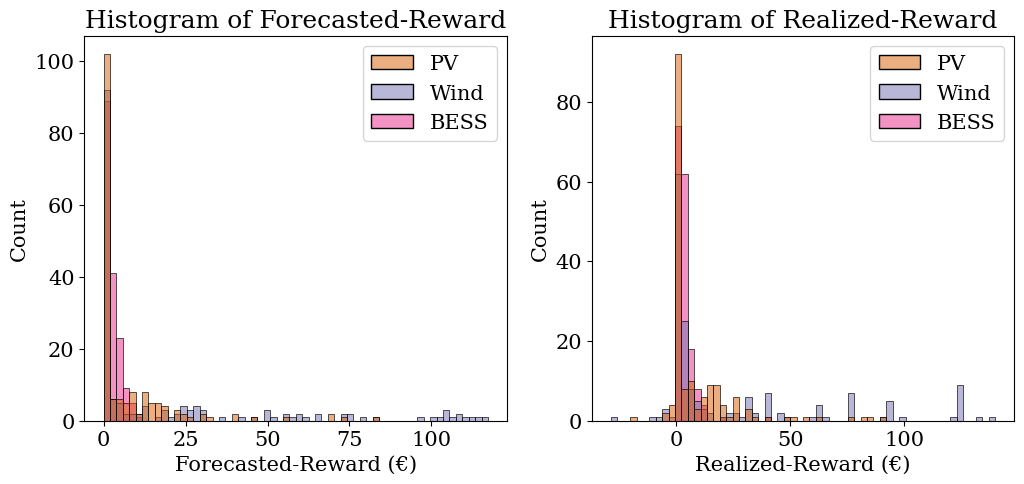

In [245]:
# only plot rewad, not values
df_plot_2 = df_rewards.loc(axis=0)[:, ['Forecasted-Reward', 'Realized-Reward']]

# make 4 subplots axis
fig, axs = plt.subplots(1,2, figsize=(12, 5))

for i, x in enumerate(df_plot_2.index.get_level_values(1).unique().values):
    sns.histplot(df_plot_2.loc(axis=0)[:, x], bins=60, ax=axs[i])
    axs[i].set_title(f'Histogram of {x}')
    axs[i].set_xlabel(f'{x} (€)')
    
    # fit_results = assess_distribution_fit([x for xs in df_plot.loc(axis=0)[:, x].values for x in xs], test_dists)
    # print(fit_results)
    # print the numer of values above
    vals = [xs for x in df_plot_2.loc(axis=0)[:, x].values for xs in x[:3]]
    thresh = 20
    above_thresh, above_count = sum(v for v in vals if v > thresh), sum(1 for v in vals if v > thresh)
    below_thresh, below_count = sum(v for v in vals if 0 <= v <= thresh), sum(1 for v in vals if 0 <= v <= thresh)
    print(f'For {x}, {above_thresh:.1f} values above {thresh}, {below_thresh:.1f} values below or equal to {thresh}.')
    print(f'For {x}, {above_count} counts above {thresh}, {below_count} counts below or equal to {thresh}.')
    print(f'{100*above_count/(above_count+below_count):.2f}% of values make up {100*above_thresh/(above_thresh+below_thresh):.2f}% of the total reward.')

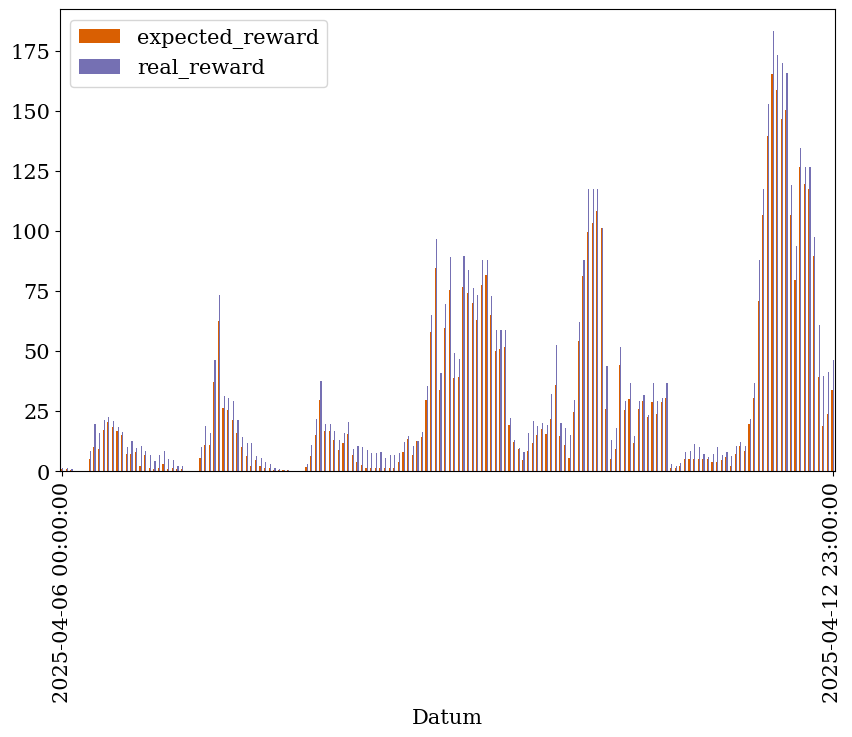

In [246]:
df_exp_real = dvpps_infos[service].groupby(level=0)[['expected_reward', 'real_reward']].mean()
# df_exp_real['diff'] = df_exp_real['real_reward'] - df_exp_real['expected_reward']
df_exp_real.plot.bar(figsize=(10,6))
# set x axis labels as only start and end time and 5 time points in between
plt.xticks([0, len(df_exp_real)-1], [df_exp_real.index[0], df_exp_real.index[-1]])
plt.show()

## compare to other BESS size

In [273]:
# get PATH
path_BESS = 'pics/mp_optimal_spring/'
# get data
opt_df_expected = pd.read_csv(f'{path_BESS}expected_values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_expected.columns = [tuple(c for c in col if c!='nan') for col in opt_df_expected.columns.values]
opt_df_realized = pd.read_csv(f'{path_BESS}values_DPF.csv', index_col=[0,1], header=[0,1,2])
opt_df_realized.columns = [tuple(c for c in col if c!='nan') for col in opt_df_realized.columns.values]
# evaluate rewards
opt_df_rewards = evaluate_full_game(opt_df_expected, opt_df_realized, MAKE_games_superadditive=MAKE_games_superadditive,
                                MAKE_REALIZED_SUPERADDITIVE=MAKE_REALIZED_SUPERADDITIVE,
                                print_warnings=False)

In [274]:
df_compare = pd.DataFrame(columns=devices, index=['Ilmar Power Plant', 'Ilmar + Large BESS'])
# get optimal rewards
opt_rewards = opt_df_rewards.xs('Realized', level=1)[devices].groupby(level=1).mean()
df_compare.loc['Ilmar + Large BESS'] = opt_rewards.loc['Reward']
df_compare.loc['Ilmar Power Plant'] = df_rewards[devices].groupby(level=1).mean().loc['Realized-Reward']

In [275]:
df_compare = df_compare.transpose()

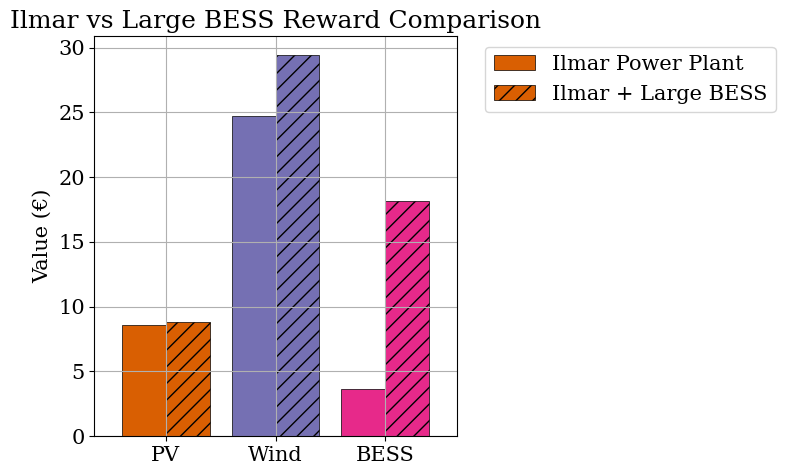

In [276]:
# plot df_compare in bar plot
fig, ax = plt.subplots(figsize=(8, 5))
df_compare.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    # if col_idx in [0, 1]:
    #     alpha = 0.5
        
    # "bars 2 and 4 should be hatch='//'" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_compare.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Ilmar vs Large BESS Reward Comparison")
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
plt.tight_layout()
plt.grid()
# plt.savefig('custom_bar_plot.png')

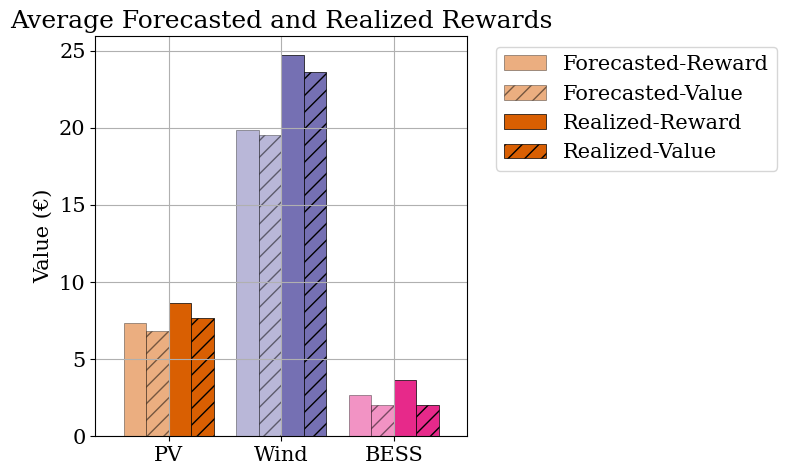

In [251]:
# plot Ilmar vs Optimal BESS
fig, ax = plt.subplots(figsize=(8, 5))
df_mean.plot(kind='bar', ax=ax, width=0.8, edgecolor='black', linewidth=0.5)

for col_idx, container in enumerate(ax.containers):
    # --- Determine Style per Column ---
    alpha = 1.0
    hatch = None
    
    # "bars 1 and 2 should be alpha=.5" -> indices 0 and 1
    if col_idx in [0, 1]:
        alpha = 0.5
        
    # "bars 2 and 4 should be hatch='//'" -> indices 1 and 3
    if col_idx in [1, 3]:
        hatch = '//'
        
    # --- Apply to each bar in the group ---
    # We zip with df_mean.index to know which device (PV/Wind/BESS) the bar belongs to
    for bar, label in zip(container, df_mean.index):
        # Set Color based on device (row index)
        color = device_colors.get(label)
        bar.set_facecolor(color)
        
        # Set Alpha
        bar.set_alpha(alpha)
        
        # Set Hatch
        bar.set_hatch(hatch)

# Final Formatting
ax.set_ylabel(r"Value (€)")
ax.set_title(r"Average Forecasted and Realized Rewards")
plt.xticks(rotation=0) # Keep labels horizontal
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Move legend out
plt.tight_layout()
plt.grid()
# plt.savefig('custom_bar_plot.png')

## compare to other seasons

In [252]:
path2 = 'pics/mp_ilmar_summer/'
path3 = 'pics/mp_ilmar_autumn/'

# TODO

## Analyze some individual games

In [253]:
from src.get_optimal_bid import get_optimal_bid
import numpy as np

In [254]:
# Get the Tab20 colormap
cmap = plt.cm.get_cmap("tab20")
# Extract the first 4 colors
base_colors = [cmap(i) for i in range(10)]
# Create extended cycle: first full alpha, then alpha=0.5
# colors = base_colors + [(r, g, b, 0.5) for (r, g, b, _) in base_colors]
# Set this as default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)

C:\Users\carlv\AppData\Local\Temp\ipykernel_15924\216728504.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")


In [255]:
# load bids dataframe
df_bids = pd.read_csv(f'{main_path}/bids_DPF_{service}.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d %H:%M:%S')

In [256]:
def map_idx_to_datetime(idx):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    return pd.Timestamp(vals[idx])
def map_datetime_to_idx(dt):
    vals = dvpps_infos[service].index.get_level_values(0).unique().values
    for i, v in enumerate(vals):
        if v == dt:
            return i
    return None

In [257]:
dict_idxs = {}
dict_realized_type_game = {}
for type_game in GAME_types_to_plot:
    dict_idxs[type_game] = df_rewards[df_rewards['Method']==type_game].index.get_level_values(0).unique()
    dict_realized_type_game[type_game] = df_rewards.loc[(dict_idxs[type_game], 'Realized-Reward'), 'Method-Realized'].values
    dict_idxs[type_game] = pd.to_datetime(dict_idxs['Shapley'])

In [258]:
def bid_value(bids, rho, bid,
              return_prob=False):
    gamma = sum(rho for b in bids if b >= bid)
    if return_prob:
        return gamma
    return bid * (4 * gamma - 3)

In [259]:
def bids_to_values(bids, rho, return_prob=False) -> np.ndarray:
    values = np.array([bid_value(bids, rho, b, return_prob=False) for b in bids])
    if not return_prob:
        return values
    else:
        gammas = np.array([bid_value(bids, rho, b, return_prob=True) for b in bids])
        return gammas, values

In [260]:
cols = df_bids.columns
idx_tuples = [eval(col) for col in df_bids.columns.values]
idx_frozensets = [frozenset(tup) for tup in idx_tuples]
the_map = {fs: col for fs, col in zip(idx_frozensets, cols)}

In [261]:
MAP_METHOD_TO_TYPE = {'Shapley': 'Convex', 'Nucleolus': 'Supperadditive/Non-Empty Core', 'Sub-Game': 'Empty Core'}

## individual times plotting

At hour 2025-04-09 19:00:00, optimal partition is [frozenset({'PV', 'Wind'}), frozenset({'BESS'})] with value 79.28155.
Coalition frozenset({'PV', 'Wind'}) max value at index 0, bid: 12.589, value: 12.589
Coalition frozenset({'BESS'}) max value at index 0, bid: 0.625, value: 0.625
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 12.921, value: 12.921
Forecasted Game Values:
(PV,)                0.00000
(Wind,)             72.33465
(BESS,)              3.75000
(PV, Wind)          75.53155
(PV, BESS)           3.75000
(Wind, BESS)        74.38911
(PV, Wind, BESS)    77.52865
Name: (FFR + FCR-D, 2025-04-09 19:00:00), dtype: float64
Realized Game Values:
(PV,)                0.00000
(Wind,)             93.63892
(BESS,)              3.75000
(PV, Wind)          93.63892
(PV, BESS)           3.75000
(Wind, BESS)        88.29932
(PV, Wind, BESS)    88.29932
Name: (FFR + FCR-D, 2025-04-09 19:00:00), dtype: float64
Forecasted and Realized rewards:
                        PV

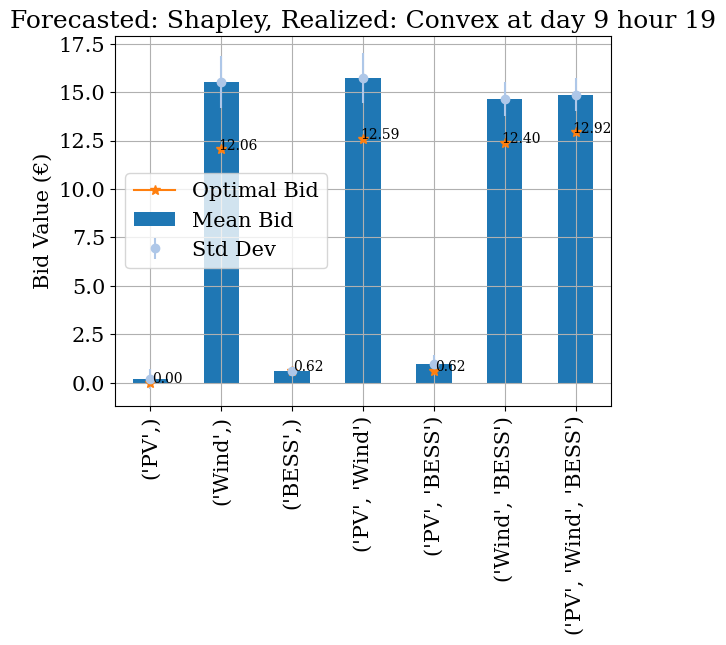

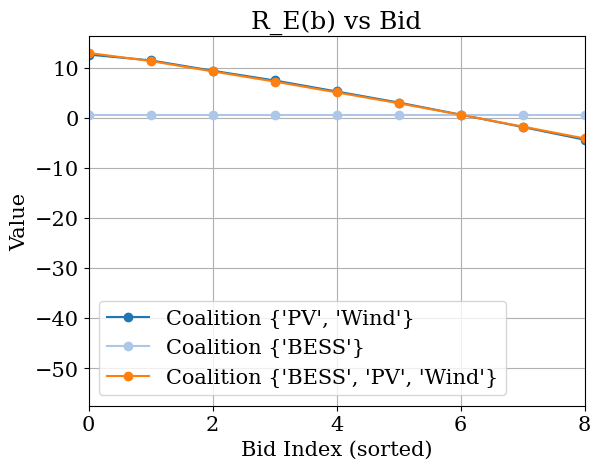

Bids are invalid (max bid: -0.300, mean bid: -0.300), submitting 0 bid (not participating).
At hour 2025-04-09 21:00:00, optimal partition is [frozenset({'PV', 'Wind'}), frozenset({'BESS'})] with value 68.12705.
Coalition frozenset({'PV', 'Wind'}) max value at index 0, bid: 13.055, value: 13.055
Coalition frozenset({'BESS'}) max value at index 0, bid: 0.625, value: 0.625
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 13.052, value: 13.052
Forecasted Game Values:
(PV,)                0.00000
(Wind,)             65.01455
(BESS,)              3.11250
(PV, Wind)          65.01455
(PV, BESS)           3.11250
(Wind, BESS)        64.99892
(PV, Wind, BESS)    64.99892
Name: (FFR + FCR-D, 2025-04-09 21:00:00), dtype: float64
Realized Game Values:
(PV,)                0.00000
(Wind,)             77.72030
(BESS,)              3.11250
(PV, Wind)          77.72030
(PV, BESS)           3.11250
(Wind, BESS)        73.28844
(PV, Wind, BESS)    73.28844
Name: (FFR + FCR-D, 2025

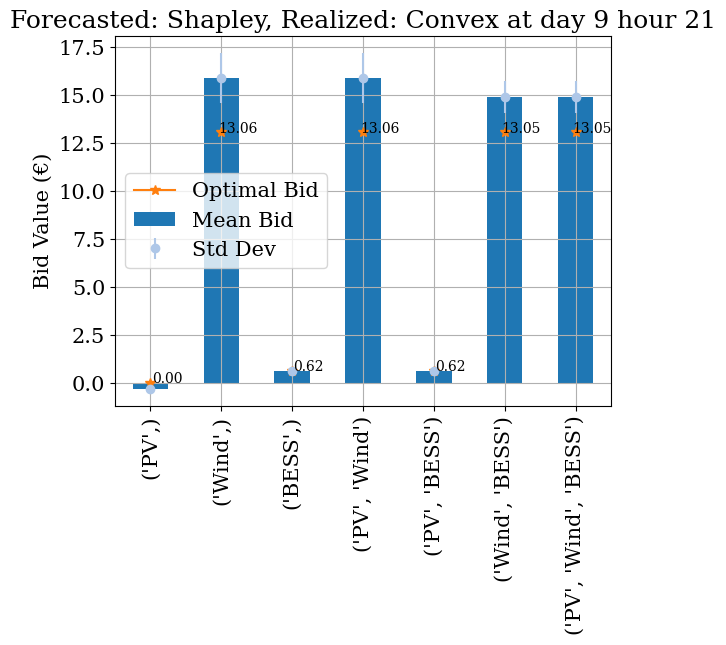

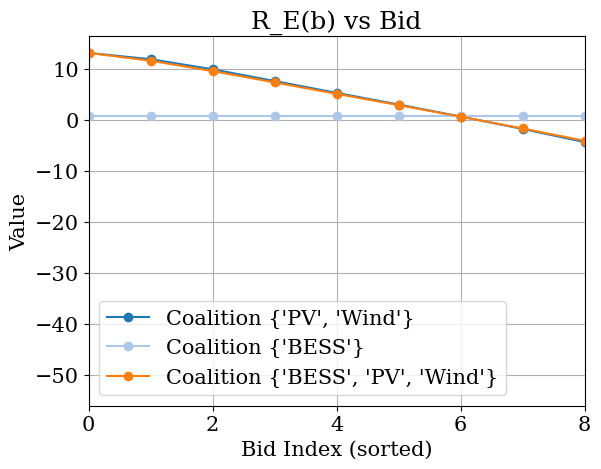

At hour 2025-04-10 10:00:00, optimal partition is [frozenset({'BESS', 'PV', 'Wind'})] with value 21.96928.
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.492, value: 5.492
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 5.492, value: 5.492
Forecasted Game Values:
(PV,)               17.38203
(Wind,)              0.00000
(BESS,)              2.50000
(PV, Wind)          11.40093
(PV, BESS)          21.96928
(Wind, BESS)         2.50000
(PV, Wind, BESS)    21.96928
Name: (FFR + FCR-D, 2025-04-10 10:00:00), dtype: float64
Realized Game Values:
(PV,)               24.24957
(Wind,)              0.00000
(BESS,)              2.50000
(PV, Wind)          17.84228
(PV, BESS)          29.66147
(Wind, BESS)         5.16522
(PV, Wind, BESS)    32.32670
Name: (FFR + FCR-D, 2025-04-10 10:00:00), dtype: float64
Forecasted and Realized rewards:
                          PV      Wind      BESS   Method Method-Realized
Forecasted-Value    17.38203       0.0

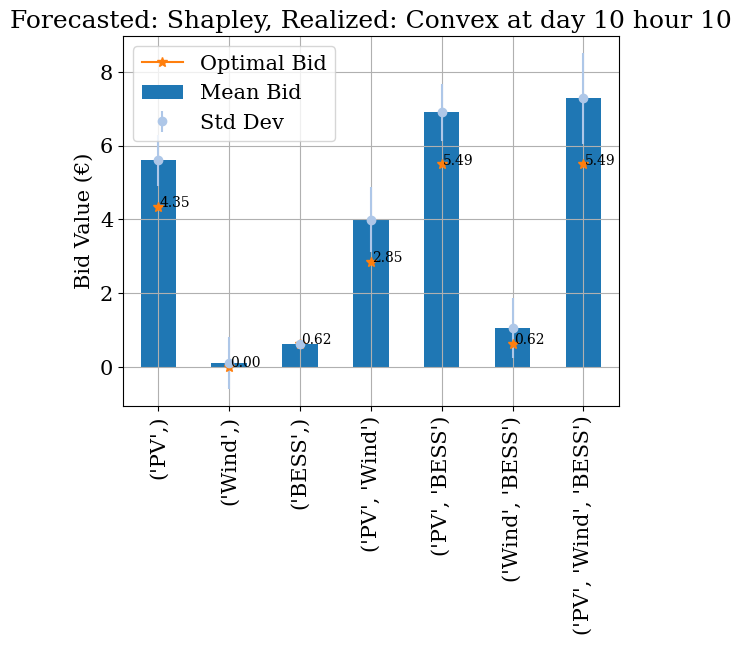

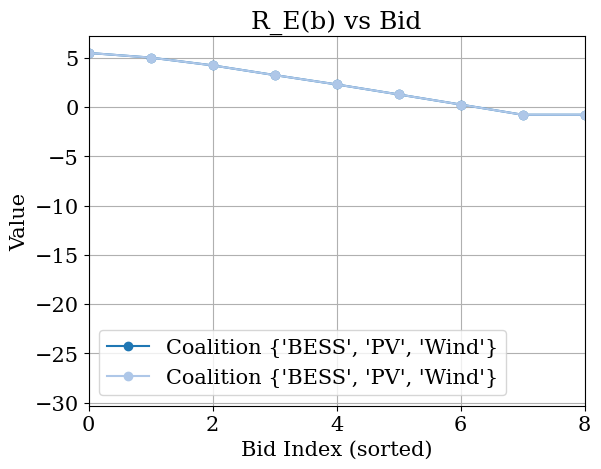

At hour 2025-04-11 07:00:00, optimal partition is [frozenset({'PV', 'Wind'}), frozenset({'BESS'})] with value 24.29941.
Coalition frozenset({'PV', 'Wind'}) max value at index 0, bid: 14.562, value: 14.562
Coalition frozenset({'BESS'}) max value at index 0, bid: 0.625, value: 0.625
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 14.110, value: 14.110
Forecasted Game Values:
(PV,)                0.31123
(Wind,)             22.37504
(BESS,)              1.00000
(PV, Wind)          23.29941
(PV, BESS)           1.02861
(Wind, BESS)        21.83037
(PV, Wind, BESS)    22.57627
Name: (FFR + FCR-D, 2025-04-11 07:00:00), dtype: float64
Realized Game Values:
(PV,)               -1.37310
(Wind,)             24.97038
(BESS,)              1.00000
(PV, Wind)          24.97038
(PV, BESS)           1.51266
(Wind, BESS)        23.54649
(PV, Wind, BESS)    23.54649
Name: (FFR + FCR-D, 2025-04-11 07:00:00), dtype: float64
Forecasted and Realized rewards:
                        PV

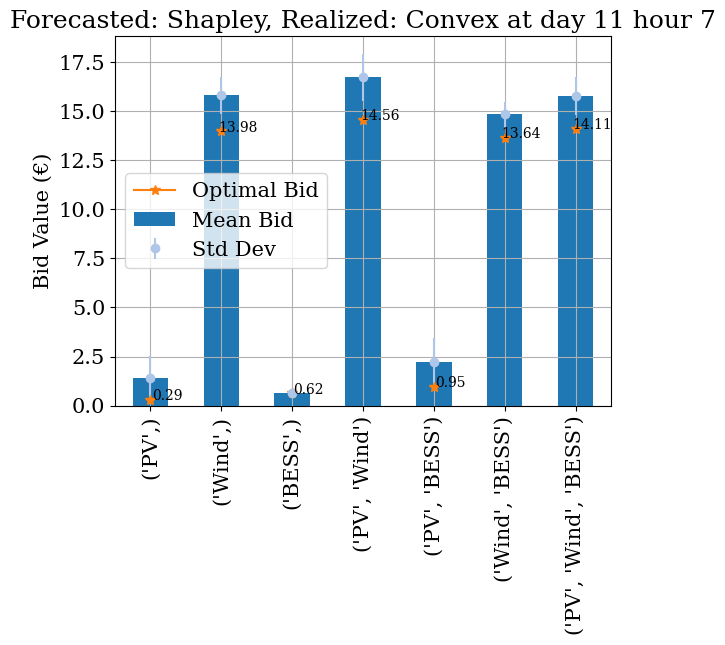

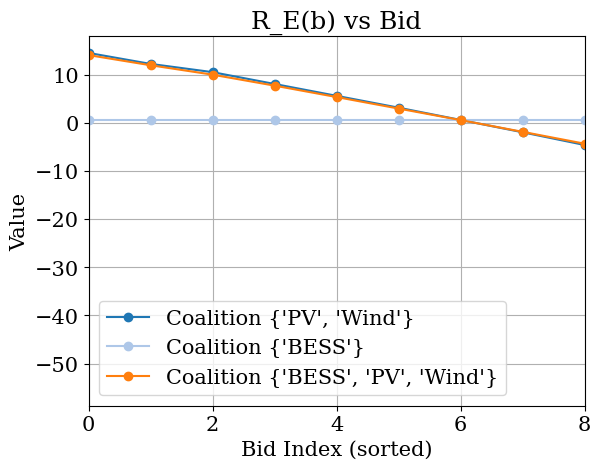

Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
Bids are invalid (max bid: 0.000, mean bid: 0.000), submitting 0 bid (not participating).
At hour 2025-04-07 05:00:00, optimal partition is [frozenset({'BESS', 'PV', 'Wind'})] with value 0.0.
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 0.000, value: 0.000
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 0.000, value: 0.000
Forecasted Game Values:
(PV,)               0.0
(Wind,)             0.0
(BESS,)       

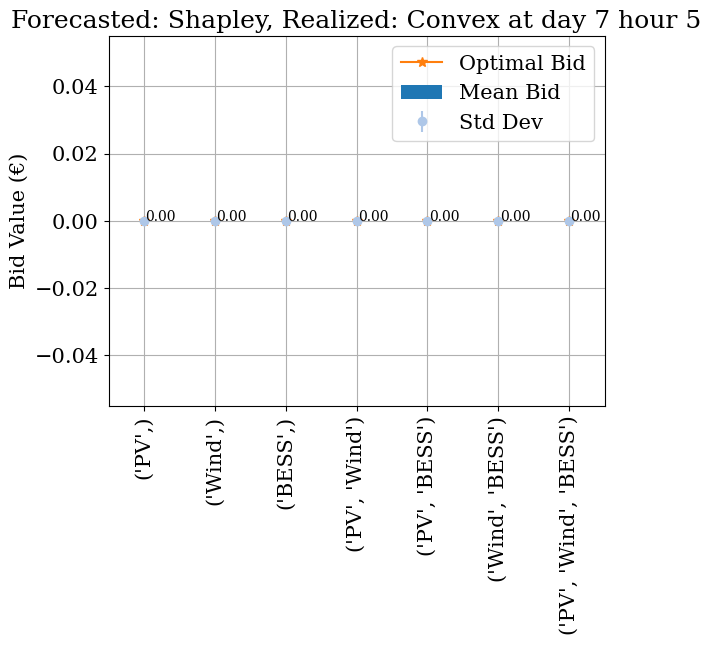

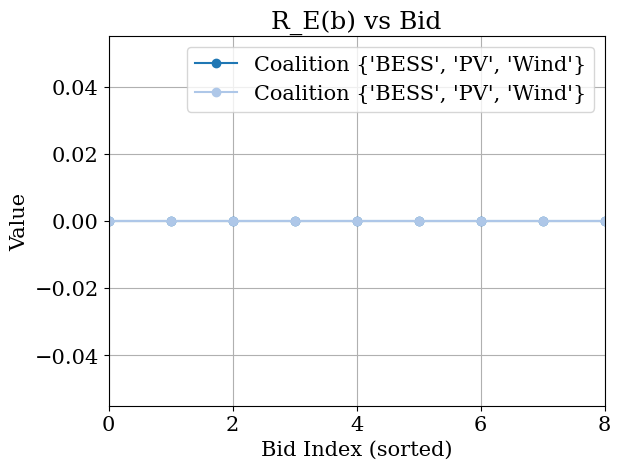

At hour 2025-04-11 06:00:00, optimal partition is [frozenset({'PV', 'Wind'}), frozenset({'BESS'})] with value 30.15488.
Coalition frozenset({'PV', 'Wind'}) max value at index 0, bid: 13.271, value: 13.271
Coalition frozenset({'BESS'}) max value at index 0, bid: 0.625, value: 0.625
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 13.440, value: 13.440
Forecasted Game Values:
(PV,)                0.59315
(Wind,)             27.19367
(BESS,)              1.35625
(PV, Wind)          28.79863
(PV, BESS)           1.36963
(Wind, BESS)        27.57639
(PV, Wind, BESS)    29.16500
Name: (FFR + FCR-D, 2025-04-11 06:00:00), dtype: float64
Realized Game Values:
(PV,)               -3.42203
(Wind,)             33.86608
(BESS,)              1.35625
(PV, Wind)          33.86608
(PV, BESS)           2.63390
(Wind, BESS)        31.93492
(PV, Wind, BESS)    31.93492
Name: (FFR + FCR-D, 2025-04-11 06:00:00), dtype: float64
Forecasted and Realized rewards:
                         P

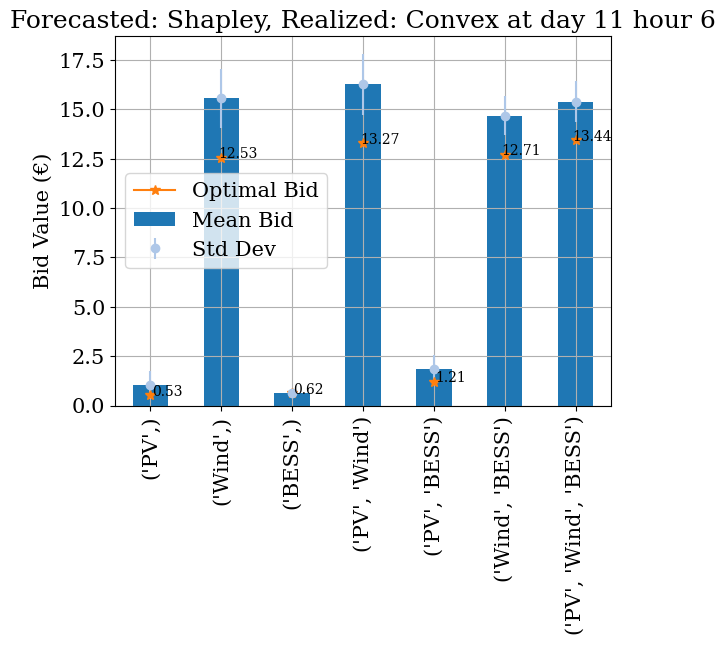

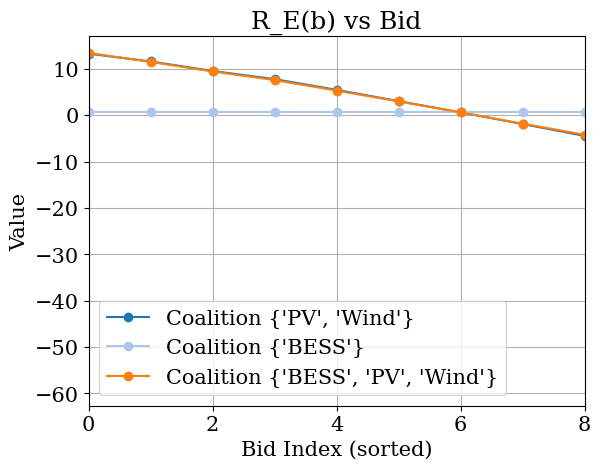

At hour 2025-04-09 08:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 63.37205.
Coalition frozenset({'Wind'}) max value at index 0, bid: 11.943, value: 11.943
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 6.163, value: 6.163
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 16.573, value: 16.573
Forecasted Game Values:
(PV,)               17.30552
(Wind,)             41.80097
(BESS,)              2.18750
(PV, Wind)          56.74828
(PV, BESS)          21.57108
(Wind, BESS)        43.11103
(PV, Wind, BESS)    58.00704
Name: (FFR + FCR-D, 2025-04-09 08:00:00), dtype: float64
Realized Game Values:
(PV,)               29.20335
(Wind,)             46.13534
(BESS,)              2.18750
(PV, Wind)          65.33244
(PV, BESS)          34.89761
(Wind, BESS)        45.93098
(PV, Wind, BESS)    65.12212
Name: (FFR + FCR-D, 2025-04-09 08:00:00), dtype: float64
Forecasted and Realized rewards:
                         P

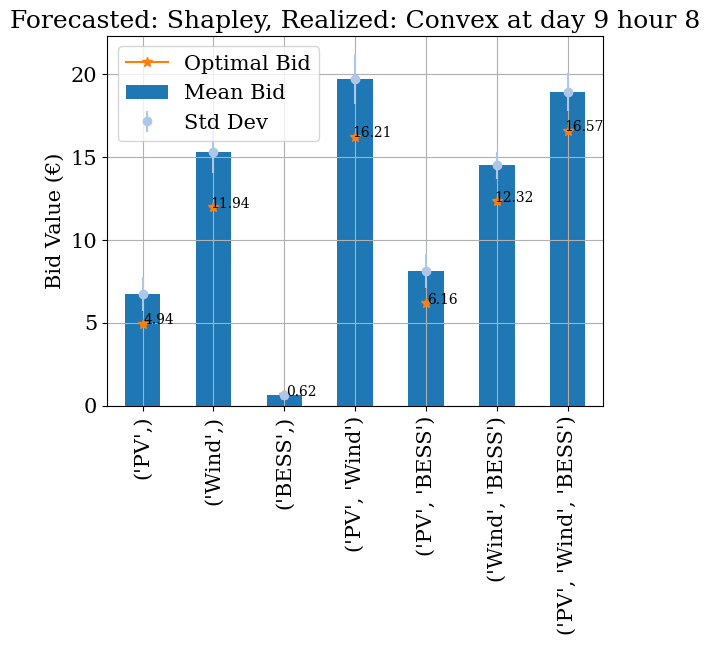

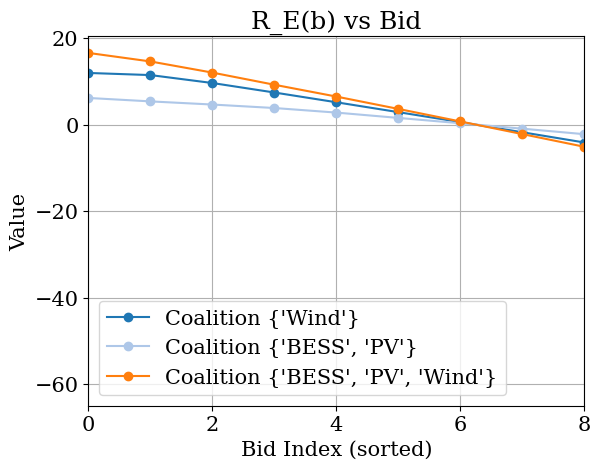

At hour 2025-04-09 15:00:00, optimal partition is [frozenset({'Wind'}), frozenset({'BESS', 'PV'})] with value 83.34388.
Coalition frozenset({'Wind'}) max value at index 0, bid: 11.545, value: 11.545
Coalition frozenset({'BESS', 'PV'}) max value at index 0, bid: 5.191, value: 5.191
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 15.429, value: 15.429
Forecasted Game Values:
(PV,)               20.30179
(Wind,)             57.49174
(BESS,)              3.11250
(PV, Wind)          74.39653
(PV, BESS)          25.85214
(Wind, BESS)        60.03855
(PV, Wind, BESS)    76.83695
Name: (FFR + FCR-D, 2025-04-09 15:00:00), dtype: float64
Realized Game Values:
(PV,)               25.03237
(Wind,)             77.72030
(BESS,)              3.11250
(PV, Wind)          94.19139
(PV, BESS)          31.15077
(Wind, BESS)        73.28844
(PV, Wind, BESS)    89.60483
Name: (FFR + FCR-D, 2025-04-09 15:00:00), dtype: float64
Forecasted and Realized rewards:
                          

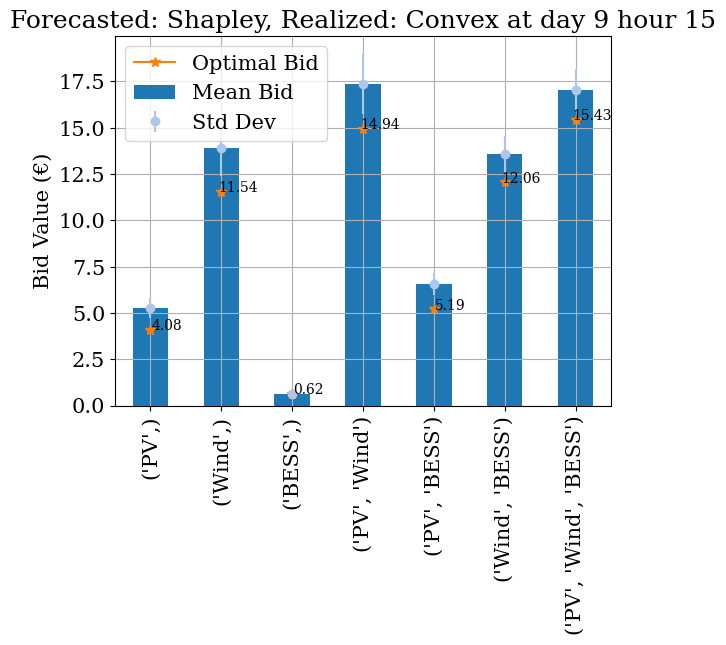

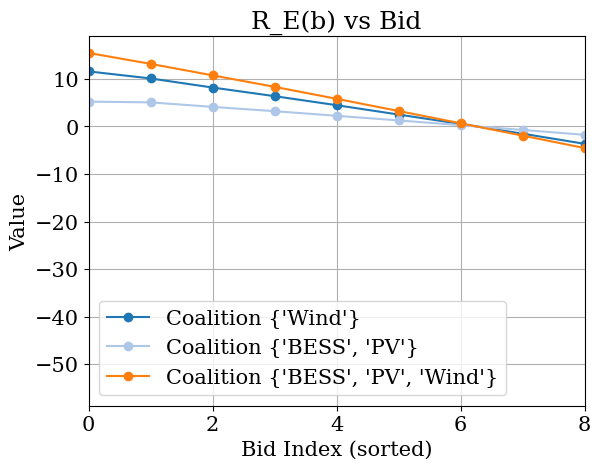

Bids are invalid (max bid: 0.527, mean bid: -0.155), submitting 0 bid (not participating).
At hour 2025-04-06 18:00:00, optimal partition is [frozenset({'BESS', 'PV', 'Wind'})] with value 7.02849.
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 1, bid: 3.347, value: 2.811
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 1, bid: 3.347, value: 2.811
Forecasted Game Values:
(PV,)               0.00000
(Wind,)             4.12993
(BESS,)             1.56250
(PV, Wind)          4.12993
(PV, BESS)          1.56250
(Wind, BESS)        7.02849
(PV, Wind, BESS)    7.02849
Name: (FFR + FCR-D, 2025-04-06 18:00:00), dtype: float64
Realized Game Values:
(PV,)                0.00000
(Wind,)            -13.60950
(BESS,)              1.56250
(PV, Wind)         -14.16123
(PV, BESS)           1.86588
(Wind, BESS)         8.36725
(PV, Wind, BESS)     8.36725
Name: (FFR + FCR-D, 2025-04-06 18:00:00), dtype: float64
Forecasted and Realized rewards:
                         PV  

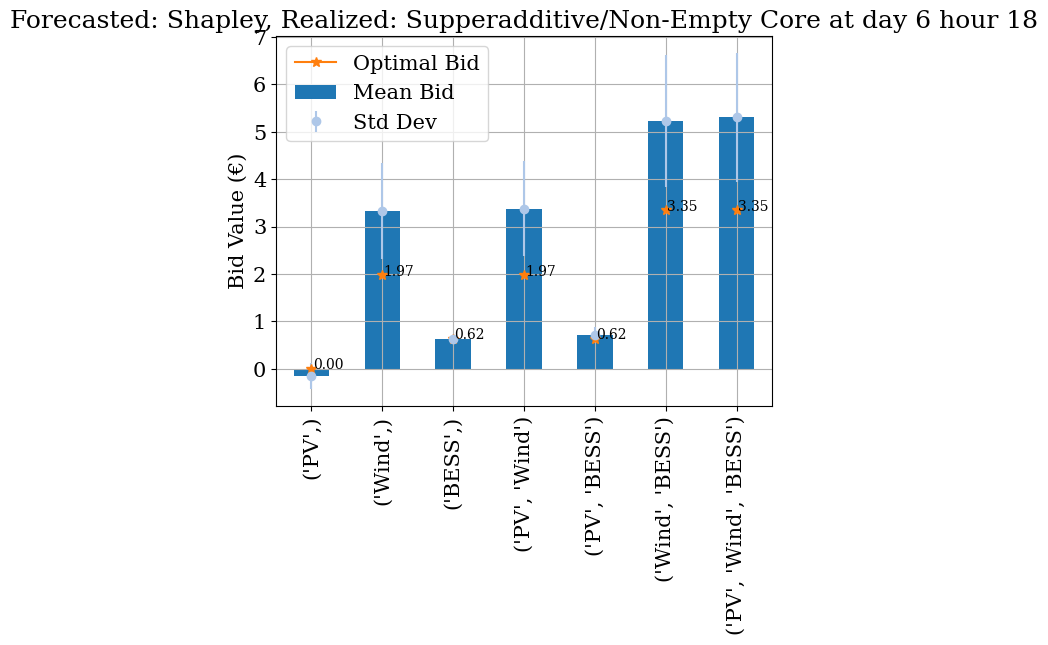

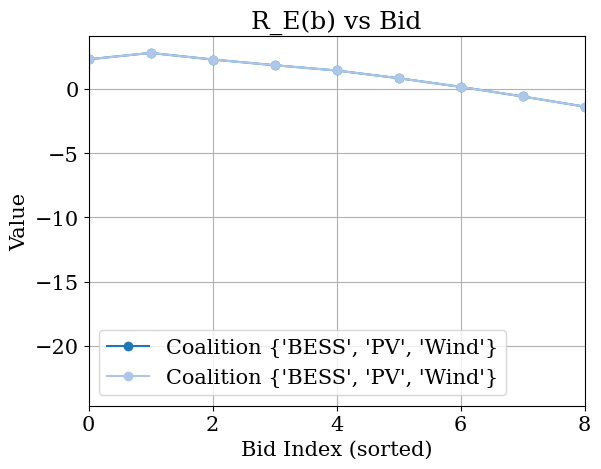

At hour 2025-04-06 15:00:00, optimal partition is [frozenset({'BESS', 'PV', 'Wind'})] with value 7.46642.
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.316, value: 4.316
Coalition frozenset({'BESS', 'PV', 'Wind'}) max value at index 0, bid: 4.316, value: 4.316
Forecasted Game Values:
(PV,)               4.39323
(Wind,)             0.44507
(BESS,)             1.08125
(PV, Wind)          3.76782
(PV, BESS)          6.00202
(Wind, BESS)        1.08125
(PV, Wind, BESS)    7.46642
Name: (FFR + FCR-D, 2025-04-06 15:00:00), dtype: float64
Realized Game Values:
(PV,)                6.63618
(Wind,)              3.16022
(BESS,)              1.08125
(PV, Wind)           7.52027
(PV, BESS)           8.51431
(Wind, BESS)         5.45512
(PV, Wind, BESS)    12.88818
Name: (FFR + FCR-D, 2025-04-06 15:00:00), dtype: float64
Forecasted and Realized rewards:
                         PV      Wind      BESS   Method Method-Realized
Forecasted-Value    4.39323   0.44507   1.08125

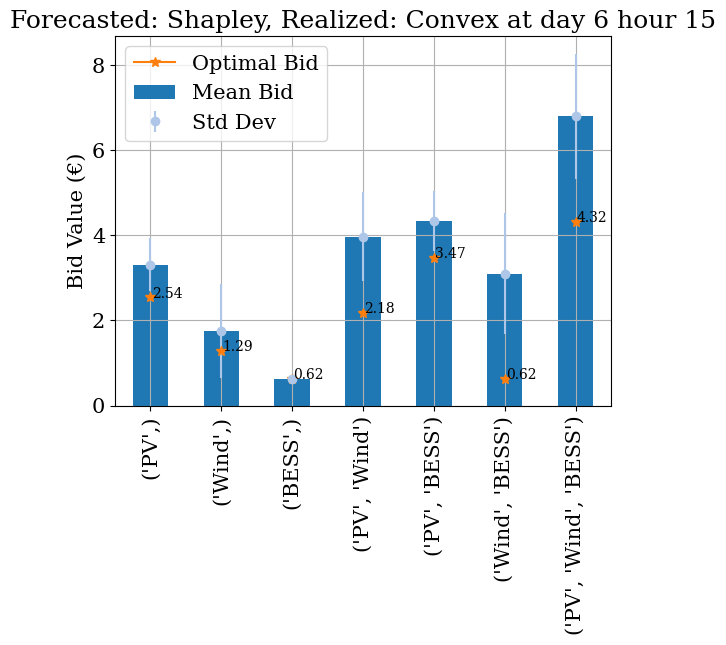

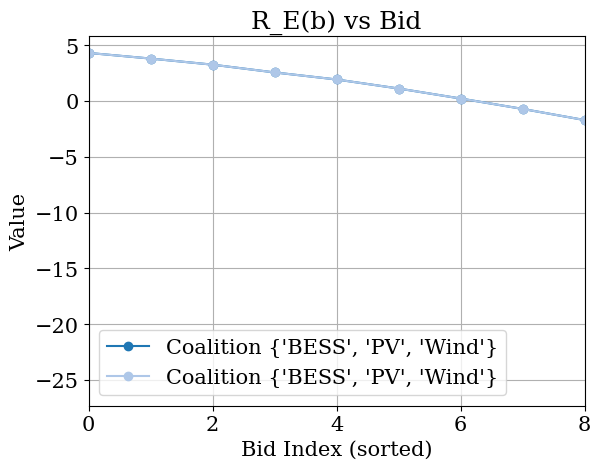

In [262]:
MAX_GAMES_TO_PLOT = 10  # max games per type to plot

type_game = 'Shapley'
# if len(dict_idxs[type_game]) == 0:
#     continue
if len(dict_idxs[type_game]) < MAX_GAMES_TO_PLOT:
    MAX_GAMES_TO_PLOT = len(dict_idxs[type_game])

# pick 5 random indexes
np.random.seed(42)
these_idxs = np.random.choice(len(dict_idxs[type_game]), size=MAX_GAMES_TO_PLOT, replace=False)

dt_idxs = dict_idxs[type_game][these_idxs]
realized_methods = dict_realized_type_game[type_game][these_idxs]

K_errors = len(df_bids.loc[dt_idxs[0]])
probs = [1/K_errors for _ in range(K_errors)]
for j, dt in enumerate(dt_idxs):
    # print(dvpps_infos[service].loc[dt])
    # visualize mean and std of each column
    plt.figure()
    plt.title(f'Forecasted: {type_game}, Realized: {MAP_METHOD_TO_TYPE[realized_methods[j]]} at day {dt.day} hour {dt.hour}')
    df_bids.loc[dt].mean(axis=0).plot(kind='bar', label='Mean Bid')
    # plot min max with error bars
    plt.errorbar(x=df_bids.loc[dt].columns, y=df_bids.loc[dt].mean(axis=0), yerr=df_bids.loc[dt].std(axis=0), fmt='o', label='Std Dev',
                color=base_colors[1])
    # compute optimal bid for each coalition and plot as star marker
    dict_opt_bids = {}
    for coalition in df_bids.loc[dt].columns:
        c_bids = np.squeeze(df_bids.loc[dt, [coalition]].values)
        b_star_coalition, value_wo_price, gamma = get_optimal_bid(c_bids, probs, return_reward=True)
        dict_opt_bids[coalition] = b_star_coalition
        # plot as star marker
        plt.plot(coalition, b_star_coalition, marker='*', markersize=7, label='Optimal Bid' if coalition==df_bids.loc[dt].columns[0] else "", color=base_colors[2])
        # annotate value of optimal bid to the right of the star
        plt.annotate(f'{b_star_coalition:.2f}', (coalition, b_star_coalition), textcoords="offset points", xytext=(12, 0), ha='center', fontsize=10)
    plt.ylabel('Bid Value (€)')
    plt.grid()
    plt.legend()

    # next, also plot th eindividual bids in line chart for non-superadditiv coalitions
    idx_str = str(dt)        
    v = {frozenset(k): val for k, val in df_expected.loc[(service, idx_str)].items()}
    v[frozenset()] = 0.0  # ensure empty set has value 0
    max_value, coalitions = solve_optimal_partition(v)
    print(f'At hour {dt}, optimal partition is {coalitions} with value {max_value}.')
    # plot line chart for this coalition
    plt.figure()
    x_ks = np.arange(K_errors)
    # add grand coalition
    coalitions.append(frozenset(players))

    for coalition in coalitions:
        # convert to columns
        col = the_map[coalition]
        the_bids = df_bids.loc[dt, col].values.tolist()
        the_bids.sort()
        # the_bids = the_bids[::-1]
        # convert bids to values
        vals = bids_to_values(the_bids, probs[0])
        # indicate dict_opt_bids in plot
        plt.plot(x_ks, vals, marker='o', label=f'Coalition {set(coalition)}')
        # print idx and bid of max value
        max_idx = np.argmax(vals)
        print(f"Coalition {coalition} max value at index {max_idx}, bid: {the_bids[max_idx]:.3f}, value: {vals[max_idx]:.3f}")

    # print forecasted and realized game values and reward splits
    print("Forecasted Game Values:")
    print(df_expected.loc[(service, idx_str)])
    print("Realized Game Values:")
    print(df_realized.loc[(service, idx_str)])
    print("Forecasted and Realized rewards:")
    print(df_rewards.loc[idx_str])

    plt.xlabel('Bid Index (sorted)')
    plt.ylabel('Value')
    plt.title('R_E(b) vs Bid')
    plt.grid(True)
    plt.xlim((0, 8))
    plt.legend()
    plt.show()

## Plot Examples for Convex, Non-Empty Core and Sub-Coaltiions

In [263]:
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = 14.9
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 15
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = 22.1
v[frozenset({'PV', 'Wind', 'BESS'})] = 22.2

In [264]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 0.1
v[frozenset({'Wind'})] = -44.6
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = -45.1
v[frozenset({'PV', 'BESS'})] = 0.1
v[frozenset({'Wind', 'BESS'})] = -66.3
v[frozenset({'PV', 'Wind', 'BESS'})] = -66.7

In [265]:
# realized game
v = {}
v[frozenset()] = 0
v[frozenset({'PV'})] = 15.9
v[frozenset({'Wind'})] = 40.2
v[frozenset({'BESS'})] = 0
v[frozenset({'PV', 'Wind'})] = 53.1
v[frozenset({'PV', 'BESS'})] = 30.3
v[frozenset({'Wind', 'BESS'})] = 43.6
v[frozenset({'PV', 'Wind', 'BESS'})] = 58.1

In [266]:
v[frozenset({'PV'})] + v[frozenset({'Wind'})]

56.1

In [267]:
v_new = make_game_superadditive(v, ['PV', 'Wind', 'BESS'])

In [268]:
v_new

{frozenset(): 0,
 frozenset({'PV'}): 15.9,
 frozenset({'Wind'}): 40.2,
 frozenset({'BESS'}): 0,
 frozenset({'PV', 'Wind'}): 56.1,
 frozenset({'BESS', 'PV'}): 30.3,
 frozenset({'BESS', 'Wind'}): 43.6,
 frozenset({'BESS', 'PV', 'Wind'}): 70.5}

In [269]:
is_convex_game(v_new, ['PV', 'Wind', 'BESS'], print_warnings=True)

Game is not convex: frozenset({'BESS', 'PV'}), frozenset({'BESS', 'Wind'})


False

In [270]:
get_shapley_value(v, ['PV', 'Wind', 'BESS'])

{'PV': 17.333333333333332,
 'Wind': 36.13333333333333,
 'BESS': 4.633333333333333}

In [271]:
from src.game_theory_helpers import is_convex_game, game_is_superadditive, core_nonempty

In [272]:
core_nonempty(v, ['PV', 'Wind', 'BESS'])

False